In [1]:
import torch
import typing
import io
import os
import colorsys
import argparse
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from urllib.request import urlretrieve
from utils.dataset import *

from PIL import Image
from torchvision import transforms
from models.make_model import make_model

from models.modeling import VisionTransformer, CONFIGS
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

In [2]:

# Prepare Model
config = CONFIGS["R50-ViT-B_16"]
model = make_model(config, None, zero_head=True, num_classes=4, vis=True)
checkpoint=torch.load('./trained_models/AFD_tp02_cw4_rp_sd3567_6500_5_10_20_5e-3_bs16_wd5e-5_ly4_np5.log_checkpoint.bin')
model.load_state_dict(checkpoint)
model.eval()

transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.CenterCrop((448,448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


===========building transformer===========


In [3]:
data_name="AFD"
dataset=eval(data_name)(root='./data/'+data_name, is_train=True, transform=transform)
train_sampler = RandomSampler(dataset)
train_loader = DataLoader(dataset,sampler=train_sampler,batch_size=1,num_workers=4,pin_memory=True)

In [4]:
def generate_colors(num_colors):
    """
    Generate distinct value by sampling on hls domain.

    Parameters
    ----------
    num_colors: int
        Number of colors to generate.

    Returns
    ----------
    colors_np: np.array, [num_colors, 3]
        Numpy array with rows representing the colors.

    """
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = 0.5
        saturation = 0.9
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    colors_np = np.array(colors)*255.

    return colors_np

def show_att_on_image(img, mask, output):
    """
    Convert the grayscale attention into heatmap on the image, and save the visualization.

    Parameters
    ----------
    img: np.array, [H, W, 3]
        Original colored image.
    mask: np.array, [H, W]
        Attention map normalized by subtracting min and dividing by max.
    output: str
        Destination image (path) to save.

    Returns
    ----------
    Save the result to output.

    """
    img_h, img_w = img.size[0], img.size[1]
    plt.subplots(nrows=1, ncols=1, figsize=(0.02*img_h, 0.02*img_w))
    plt.axis('off')
    plt.imshow(img, alpha=1)
    normed_mask = mask / mask.max()
    normed_mask = (normed_mask * 255).astype('uint8')
    plt.imshow(normed_mask, alpha=0.5, interpolation='nearest', cmap='jet')
    
    plt.savefig(output)
    plt.close()
    #heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    #heatmap = np.float32(heatmap) / 255

    # add heatmap onto the image
    #merged = heatmap + np.float32(img)

    # re-scale the image
    #merged = merged / np.max(merged)
    #cv2.imwrite(output, np.uint8(255 * merged))

def plot_assignment(root, assign_hard, num_parts):
    """
    Blend the original image and the colored assignment maps.

    Parameters
    ----------
    root: str
        Root path for saving visualization results.
    assign_hard: np.array, [H, W]
        Hard assignment map (int) denoting the deterministic assignment of each pixel. Generated via argmax.
    num_parts: int, number of object parts.

    Returns
    ----------
    Save the result to root/assignment.png.

    """
    # generate the numpy array for colors
    colors = generate_colors(num_parts)

    # coefficient for blending
    coeff = 0.4

    # load the input as RGB image, convert into numpy array
    input = Image.open(os.path.join(root, 'input.png')).convert('RGB')
    input_np = np.array(input).astype(float)

    # blending by each pixel
    for i in range(assign_hard.shape[0]):
        for j in range(assign_hard.shape[1]):
            assign_ij = assign_hard[i][j]
            input_np[i, j] = (1-coeff) * input_np[i, j] + coeff * colors[assign_ij]

    # save the resulting image
    im = Image.fromarray(np.uint8(input_np))
    im.save(os.path.join(root, 'assignment.png'))


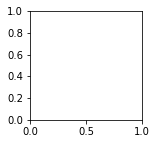

In [5]:
fig_rows = 1
fig_cols = 1
f_assign, axarr_assign = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*2,fig_rows*2))

root=os.path.join('./visualization',data_name)
with torch.no_grad():
    for i,data in enumerate(train_loader):
        if i>=200:break
        dir_path_assign=os.path.join(root,str(i),'assignments')
        dir_path_attn=os.path.join(root,str(i),'attention_map')
        os.makedirs(dir_path_assign, exist_ok=True)
        os.makedirs(dir_path_attn, exist_ok=True)
        x , label=data[0].squeeze(0),data[1]
        logits, assign, att_mat= model(x.unsqueeze(0))
        att_mat = torch.stack(att_mat).squeeze(1)
        ### visualize attention map
        att_mat = torch.mean(att_mat, dim=1)
        residual_att = torch.eye(att_mat.size(1))
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

        # Recursively multiply the weight matrices
        joint_attentions = torch.zeros(aug_att_mat.size())
        joint_attentions[0] = aug_att_mat[0]

        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
        # Attention from the output token to the input space.
        v = joint_attentions[-1]
        size=assign.shape
        assign_attn=torch.mul(v[0, 1:].unsqueeze(1),assign.flatten(-2))
        assign_attn=assign_attn.view(*size)
        
        save_input = transforms.Normalize(mean=(0, 0, 0),std=(1/0.229, 1/0.224, 1/0.225))(x.data.cpu())
        save_input = transforms.Normalize(mean=(-0.485, -0.456, -0.406),std=(1, 1, 1))(save_input)
        save_input = torch.nn.functional.interpolate(save_input.unsqueeze(0), size=(448, 448), mode='bilinear', align_corners=False).squeeze(0)
        img = torchvision.transforms.ToPILImage()(save_input)

        img.save(dir_path_assign+"/input.png")
        img.save(dir_path_attn+"/input.png")
        assign_reshaped = torch.nn.functional.interpolate(assign.data.cpu(), size=(448, 448), mode='bilinear', align_corners=False)
        assign_attn_reshaped = torch.nn.functional.interpolate(assign_attn.data.cpu(), size=(448, 448), mode='bilinear', align_corners=False)
        _, assign = torch.max(assign_reshaped, 1)
        _, assign_attn = torch.max(assign_attn_reshaped, 1)
        attn_mask = torch.sum(assign_attn_reshaped, 1)
        # colorize and save the assignment
        plot_assignment(dir_path_assign, assign.squeeze(0).numpy(), 5)
        show_att_on_image(img, attn_mask.squeeze(0).numpy(), os.path.join(dir_path_attn,'heatmap.png'))

        # plot the assignment for each dictionary vector
        for i in range(5):
            img = torch.nn.functional.interpolate(assign_reshaped.data[:, i].cpu().unsqueeze(0), size=(448, 448), mode='bilinear', align_corners=False)
            img = torchvision.transforms.ToPILImage()(img.squeeze(0))
            img.save(os.path.join(dir_path_assign, 'part_'+str(i)+'.png'))
            
        for i in range(5):
            img = torch.nn.functional.interpolate(assign_attn_reshaped.data[:, i].cpu().unsqueeze(0), size=(448, 448), mode='bilinear', align_corners=False)
            img = torchvision.transforms.ToPILImage()(img.squeeze(0))
            img.save(os.path.join(dir_path_attn, 'part_'+str(i)+'.png'))


In [6]:
torch.cuda.is_available()

True